In [ ]:
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 2.5.0
    Uninstalling termcolor-2.5.0:
      Successfully uninstalled termcolor-2.5.0
  Attempting uninstall: prompt_toolkit
    Found existing installation: prompt_toolkit 3.0.48
    Uninstalling prompt_toolkit-3.0.48:
      Successfully uninstalled prompt_toolkit-3.0.48
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
i

In [ ]:
import collections
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression

from codecarbon import EmissionsTracker

pd.set_option('display.max_columns', None)

## Load dataset

The dataset used in this project is the US traffic data combined with weather and calendar information,
available from [Kaggle](https://www.kaggle.com/datasets/maryamshoaei/us-traffic-data-with-weather-and-calendar-dataset). It includes traffic data from the California
Performance Measurement System (PeMS)[2] for the eastbound lanes of the Ventura Highway in
Los Angeles, covering February 1 to May 31, 2020. The dataset consists of 34823 record across 17
columns.

In [ ]:
df = pd.read_csv('traffic_weather_full2020.csv')

df.head(n=1)

<ipython-input-4-6abc380faee2>:1: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('traffic_weather_full2020.csv')


,5 Minutes,Flow,(mph),week_day,holidays,Hour,Day,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition
0,2/1/2020 0:00,338,66.0,6,1,2/1/2020 0:00,2/1/2020,12:00,55 F,29 F,37.0,VAR,3,0,29.39,0.0,Fair


In [ ]:
df.tail(n=1)

,5 Minutes,Flow,(mph),week_day,holidays,Hour,Day,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition
34822,5/31/2020 23:55,163,68.9,7,1,5/31/2020 23:55,5/31/2020,11:00,64 F,53 F,67.0,SE,5,0,29.09,0.0,Fair


In [ ]:
df.shape

(34823, 17)

## Data Cleaning

We will do some cleaning including renaming columns, impute missing values.

In [ ]:
df.rename(columns={'5 Minutes': 'DateTime', '(mph)': 'speed'}, inplace=True)

In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(by=['DateTime'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34823 entries, 0 to 34822
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     34823 non-null  datetime64[ns]
 1   Flow         34823 non-null  int64         
 2   speed        34823 non-null  float64       
 3   week_day     34823 non-null  int64         
 4   holidays     34823 non-null  int64         
 5   Hour         34823 non-null  object        
 6   Day          34823 non-null  object        
 7   Time         34823 non-null  object        
 8   Temperature  34823 non-null  object        
 9   Dew Point    34823 non-null  object        
 10  Humidity     34823 non-null  float64       
 11  Wind         34655 non-null  object        
 12  Wind Speed   34823 non-null  object        
 13  Wind Gust    34823 non-null  object        
 14  Pressure     34823 non-null  float64       
 15  Precip.      34823 non-null  float64       
 16  Cond

In [ ]:
# remove Time
df = df.drop(columns=['Time'])
# extract hour from Hour
df['Hour'] = pd.to_datetime(df['Hour']).dt.hour

In [ ]:
df['Wind Speed'] = df['Wind Speed'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

In [ ]:
df['Dew Point'] = df['Dew Point'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

In [ ]:
df['Temperature'] = df['Temperature'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

In [ ]:
df['Wind Gust'] = df['Wind Gust'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

impute missing values

In [ ]:
df['Condition'] = df['Condition'].fillna(df['Condition'].mode()[0])

In [ ]:
df['Wind'] = df['Wind'].fillna(df['Wind'].mode()[0])

check missing values

In [ ]:
df.isnull().sum()

,0
DateTime,0
Flow,0
speed,0
week_day,0
holidays,0
Hour,0
Day,0
Temperature,0
Dew Point,0
Humidity,0


In [ ]:
df['Precip.'].unique()

array([0. , 0.1, 0.2, 0.7])

## Exploratory Data Analysis

EDA analysis is conducted to identify patterns of the features and find potential factor related to the prediction model.

In [ ]:
df.describe()

,DateTime,Flow,speed,week_day,holidays,Hour,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precip.
count,34823,34823.000000,34823.000000,34823.000000,34823.000000,34823.000000,34823.000000,34823.000000,34823.000000,34823.000000,34823.000000,34823.000000,34823.000000
mean,2020-04-01 12:15:15.851592448,408.743331,65.626080,4.039629,0.313586,11.507308,62.089539,43.625305,55.481980,5.950119,1.030698,29.162454,0.002516
min,2020-02-01 00:00:00,87.000000,24.100000,1.000000,0.000000,0.000000,35.000000,3.000000,0.130000,0.000000,0.000000,28.910000,0.000000
25%,2020-03-02 05:27:30,237.000000,65.300000,2.000000,0.000000,6.000000,55.000000,39.000000,41.000000,3.000000,0.000000,29.090000,0.000000
50%,2020-04-01 12:55:00,421.000000,67.400000,4.000000,0.000000,12.000000,61.000000,46.000000,57.000000,6.000000,0.000000,29.150000,0.000000
75%,2020-05-01 18:27:30,568.000000,68.300000,6.000000,1.000000,18.000000,68.000000,50.000000,72.000000,9.000000,0.000000,29.240000,0.000000
max,2020-05-31 23:55:00,794.000000,71.100000,7.000000,1.000000,23.000000,98.000000,60.000000,97.000000,36.000000,59.000000,29.480000,0.700000
std,NaN,178.965469,5.760817,2.009550,0.463957,6.919215,10.272577,10.174570,21.129882,4.498656,5.195910,0.099306,0.021422


flow distribution

Text(0.5, 1.0, 'Traffic Flow Distribution')

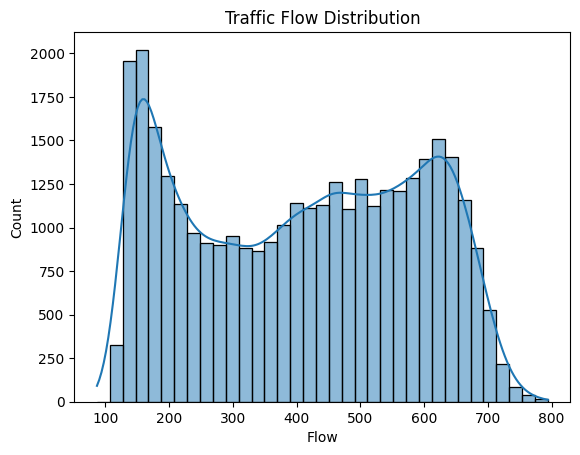

In [ ]:
sns.histplot(df['Flow'], kde=True)
plt.title('Traffic Flow Distribution')
# 100~200 and 600~700

speed distribution

Text(0.5, 0, 'Speed (mph)')

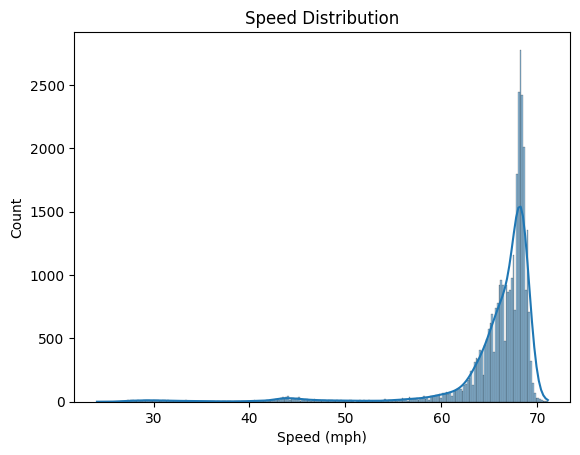

In [ ]:
sns.histplot(df['speed'], kde=True)
plt.title('Speed Distribution')
plt.xlabel('Speed (mph)')

Text(0.5, 1.0, 'Flow and Weather')

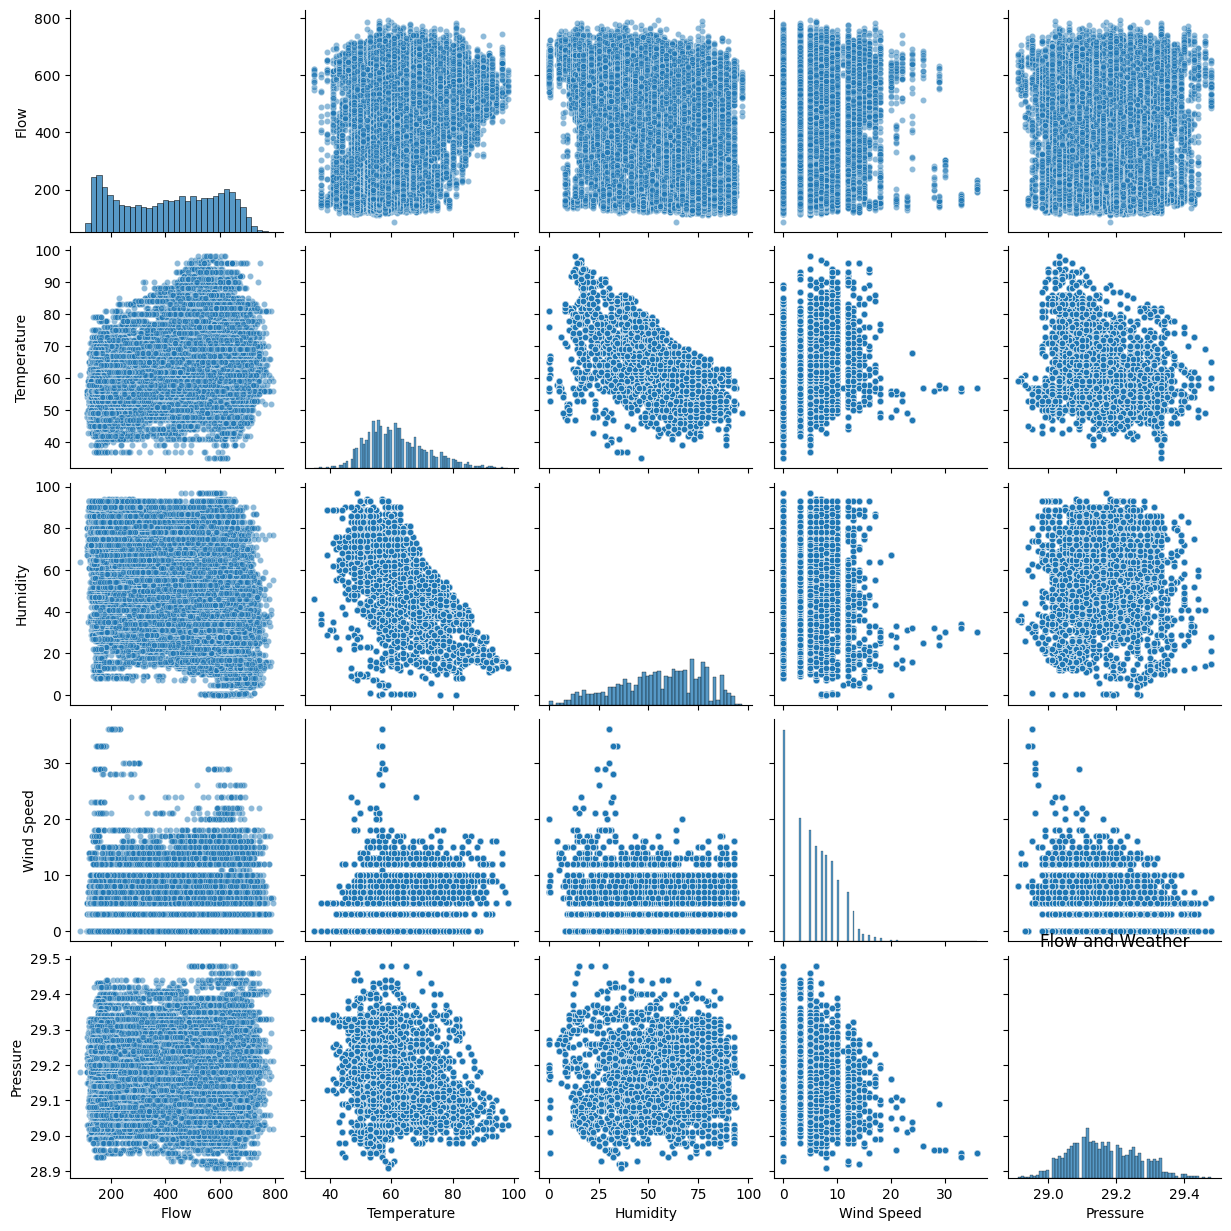

In [ ]:
# flow vs weather
sns.pairplot(df, vars=['Flow', 'Temperature', 'Humidity', 'Wind Speed', 'Pressure'], plot_kws={'s': 20, 'alpha': 0.5})
plt.title('Flow and Weather')

Text(0.5, 0, 'Speed (mph)')

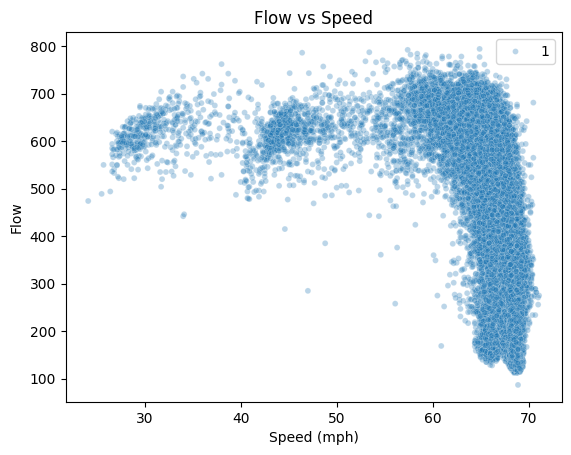

In [ ]:
sns.scatterplot(data=df, x='speed', y='Flow', size=1, alpha=0.3)
plt.title('Flow vs Speed')
plt.xlabel('Speed (mph)')

Text(0.5, 1.0, 'Pearson Correlation')

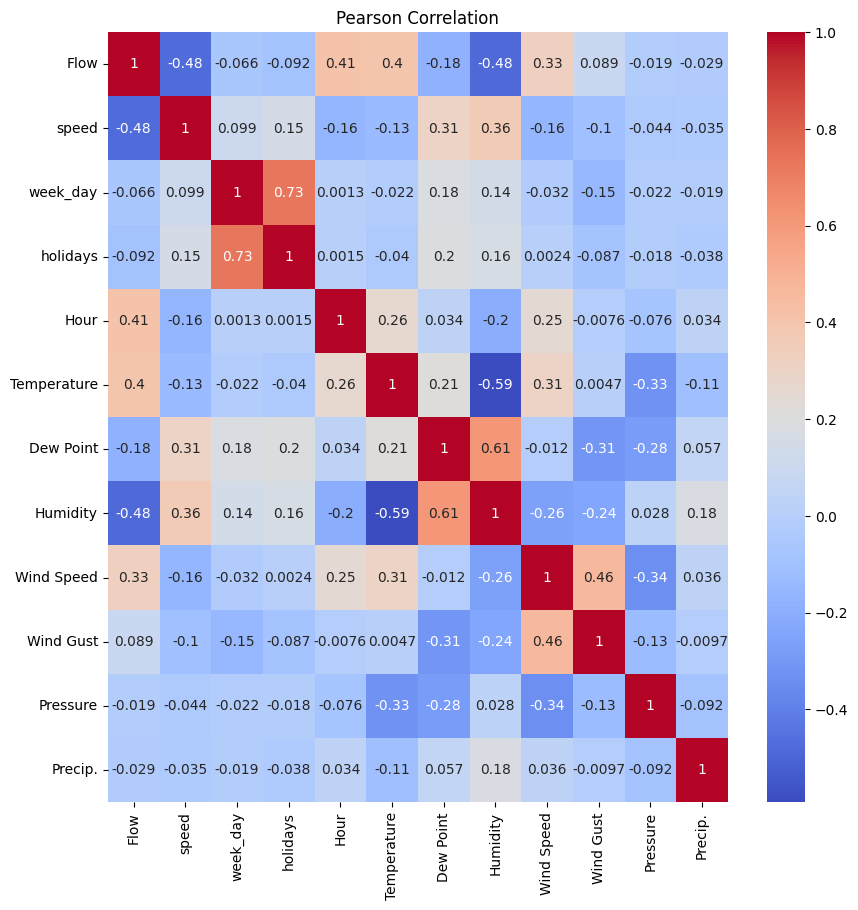

In [ ]:
plt.figure(figsize=(10, 10))
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation')

## Feature Engineering

Feature engineering including One-Hot Encoding for categorical variables, feature standardization, and data splitting for training, validation and test.

In [ ]:
# One-Hot Encoding for categorical variables
categorical_features = ['Wind', 'Condition']
df = pd.get_dummies(df, columns=categorical_features)

In [ ]:
# Feature and target selection
features = [col for col in df.columns if col not in ['DateTime', 'Day', 'Flow']]
target = 'Flow'
X = df[features]
y = df[target].values

In [ ]:
# Split the data 70% for training, 15% for validation, 15% for testing
split_index = int(df.shape[0] * 0.7)
val_index = int(df.shape[0] * 0.85)

X_train, X_val, X_test = X[:split_index], X[split_index:val_index], X[val_index:]
y_train, y_val, y_test = y[:split_index], y[split_index:val_index], y[val_index:]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
results = []

## Linear Regression

This is the baseline model. Carbon emission are also tracked.

In [ ]:
tracker = EmissionsTracker(
    output_dir="./code_carbon/",  # define the directory to which we'll write our emissions results
    output_file="linear_emissions.csv",  # define the name of the file containing our emissions results
    # log_level='error' # comment out this line to see regular output
)
tracker.start()

[codecarbon INFO @ 16:22:45] [setup] RAM Tracking...
[codecarbon INFO @ 16:22:45] [setup] GPU Tracking...
[codecarbon INFO @ 16:22:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:22:45] [setup] CPU Tracking...
[codecarbon WARNING @ 16:22:45] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 16:22:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:22:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:22:46] >>> Tracker's metadata:
[codecarbon INFO @ 16:22:46]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 16:22:46]   Python version: 3.10.12
[codecarbon INFO @ 16:22:46]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 16:22:46]   Available RAM : 12.675 GB
[codecarbon INFO @ 16:22:46]   CPU count: 2
[codeca

In [ ]:
def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

In [ ]:
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train)

# Predict on validation and test sets
y_val_pred = linear_model.predict(X_val_scaled)
y_test_pred = linear_model.predict(X_test_scaled)

In [ ]:
# Validation metrics
val_mae, val_mse, val_rmse, val_r2 = evaluate_metrics(y_val, y_val_pred)
print("Validation Metrics:")
print(f"MAE: {val_mae:.3f}, MSE: {val_mse:.3f}, RMSE: {val_rmse:.3f}, R-squared: {val_r2:.3f}")

# Test metrics
test_mae, test_mse, test_rmse, test_r2 = evaluate_metrics(y_test, y_test_pred)
print("\nTest Metrics:")
print(f"MAE: {test_mae:.3f}, MSE: {test_mse:.3f}, RMSE: {test_rmse:.3f}, R-squared: {test_r2:.3f}")

Validation Metrics:
MAE: 91.151, MSE: 12394.202, RMSE: 111.329, R-squared: 0.498

Test Metrics:
MAE: 89.862, MSE: 11420.163, RMSE: 106.865, R-squared: 0.620


In [ ]:
# Evaluate emissions
baseline_emissions = tracker.stop()
print(f"Emissions from this training run: {baseline_emissions:.5f} kg CO2eq")

[codecarbon INFO @ 16:22:46] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 16:22:46] Energy consumed for all GPUs : 0.000001 kWh. Total GPU Power : 9.385383678146196 W
[codecarbon INFO @ 16:22:46] Energy consumed for all CPUs : 0.000003 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:22:46] 0.000003 kWh of electricity used since the beginning.


Emissions from this training run: 0.00000 kg CO2eq


/usr/local/lib/python3.10/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


In [ ]:
results.append({
    'model': 'linear regression',
    'mae': test_mae,
    'mse': test_mse,
    'rmse': test_rmse,
    'r2': test_r2,
    'emission': baseline_emissions
})

## LSTM Model

LSTM model is built to predict the time series data.

In [ ]:
def create_sequences(X, y, seq_length):
    sequences_X = []
    sequences_y = []

    # Loop through and create sequences
    for i in range(len(X) - seq_length):
        seq_X = X[i:i+seq_length]
        seq_y = y[i+seq_length]  # Predict the next value after the sequence
        sequences_X.append(seq_X)
        sequences_y.append(seq_y)

    return np.array(sequences_X), np.array(sequences_y)

In [ ]:
# Set parameters
seq_length = 20  # The number of past time steps to use for prediction

# Create sequences for training, validation, and test datasets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

Using device: cuda


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initializing hidden and cell states
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Cell state

        # Passing the input through the LSTM layer
        out, _ = self.lstm(x, (h_0, c_0))

        # Taking the output from the last time step
        out = out[:, -1, :]  # Use the last time step output

        # Pass the output to the fully connected layer
        out = self.fc(out)
        return out

In [ ]:
# Training the model for regression (MSELoss and RMSE/MAE as metrics)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    metrics = collections.defaultdict(list)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Training loop
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(X_batch)  # Get model predictions
            y_batch = y_batch.unsqueeze(1)
            loss = criterion(outputs, y_batch)  # Compute the loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the weights

            train_loss += loss.item() * X_batch.size(0)  # Accumulate the loss

        train_loss /= len(train_loader.dataset)

        metrics["train_losses"].append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():  # No gradients needed for validation
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to device
                outputs = model(X_batch)  # Get model predictions
                y_batch = y_batch.unsqueeze(1)
                loss = criterion(outputs, y_batch)  # Compute the loss
                val_loss += loss.item() * X_batch.size(0)  # Accumulate the loss

        val_loss /= len(val_loader.dataset)

        metrics["valid_losses"].append(val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return metrics

In [ ]:
tracker = EmissionsTracker(
    output_dir="./code_carbon/",  # define the directory to which we'll write our emissions results
    output_file="lstm_emissions.csv",  # define the name of the file containing our emissions results
    # log_level='error' # comment out this line to see regular output
)
tracker.start()

[codecarbon INFO @ 16:22:47] [setup] RAM Tracking...
[codecarbon INFO @ 16:22:47] [setup] GPU Tracking...
[codecarbon INFO @ 16:22:47] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:22:47] [setup] CPU Tracking...
[codecarbon WARNING @ 16:22:47] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 16:22:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:22:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 16:22:49] >>> Tracker's metadata:
[codecarbon INFO @ 16:22:49]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 16:22:49]   Python version: 3.10.12
[codecarbon INFO @ 16:22:49]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 16:22:49]   Available RAM : 12.675 GB
[codecarbon INFO @ 16:22:49]   CPU count: 2
[codeca

In [ ]:
# Set parameters for the LSTM
input_size = X_train_seq.shape[2]  # Number of features per time step
hidden_size = 200# 64
num_layers = 2
output_size = 1  # Assuming a single output prediction (for regression)
learning_rate = 0.001
num_epochs = 30

# Instantiate the model
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()  # Using MSELoss for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

[codecarbon INFO @ 16:23:04] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 16:23:04] Energy consumed for all GPUs : 0.000106 kWh. Total GPU Power : 25.147117864128663 W
[codecarbon INFO @ 16:23:04] Energy consumed for all CPUs : 0.000178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:23:04] 0.000304 kWh of electricity used since the beginning.


Epoch 1, Train Loss: 172884.1217, Val Loss: 112910.1976
Epoch 2, Train Loss: 125528.8416, Val Loss: 78086.6963
Epoch 3, Train Loss: 91711.6791, Val Loss: 54528.1694
Epoch 4, Train Loss: 68319.5871, Val Loss: 39454.0816


[codecarbon INFO @ 16:23:19] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 16:23:19] Energy consumed for all GPUs : 0.000275 kWh. Total GPU Power : 40.62913966126813 W
[codecarbon INFO @ 16:23:19] Energy consumed for all CPUs : 0.000356 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:23:19] 0.000670 kWh of electricity used since the beginning.


Epoch 5, Train Loss: 52869.4636, Val Loss: 30705.3519
Epoch 6, Train Loss: 43366.3290, Val Loss: 26414.7064
Epoch 7, Train Loss: 38037.6747, Val Loss: 24885.1509
Epoch 8, Train Loss: 35402.8143, Val Loss: 24816.0376
Epoch 9, Train Loss: 34294.9432, Val Loss: 25277.2882
Epoch 10, Train Loss: 33913.3535, Val Loss: 25721.3079
Epoch 11, Train Loss: 34134.2241, Val Loss: 24500.4373
Epoch 12, Train Loss: 30633.5911, Val Loss: 16347.6834


[codecarbon INFO @ 16:23:34] Energy consumed for RAM : 0.000060 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 16:23:34] Energy consumed for all GPUs : 0.000528 kWh. Total GPU Power : 60.852030713133104 W
[codecarbon INFO @ 16:23:34] Energy consumed for all CPUs : 0.000533 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:23:34] 0.001120 kWh of electricity used since the beginning.


Epoch 13, Train Loss: 19653.6876, Val Loss: 7379.5368
Epoch 14, Train Loss: 10766.8057, Val Loss: 4303.0796
Epoch 15, Train Loss: 7275.5567, Val Loss: 4230.9059
Epoch 16, Train Loss: 5386.4824, Val Loss: 4428.9155
Epoch 17, Train Loss: 3914.8575, Val Loss: 4445.5741
Epoch 18, Train Loss: 2997.7661, Val Loss: 4684.7604
Epoch 19, Train Loss: 2468.8872, Val Loss: 4741.0296
Epoch 20, Train Loss: 2208.8323, Val Loss: 4253.3915
Epoch 21, Train Loss: 2022.9395, Val Loss: 4277.5633


[codecarbon INFO @ 16:23:49] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 16:23:49] Energy consumed for all GPUs : 0.000791 kWh. Total GPU Power : 63.04819614298245 W
[codecarbon INFO @ 16:23:49] Energy consumed for all CPUs : 0.000710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:23:49] 0.001579 kWh of electricity used since the beginning.


Epoch 22, Train Loss: 1848.0213, Val Loss: 4194.0547
Epoch 23, Train Loss: 1637.8196, Val Loss: 3932.4577
Epoch 24, Train Loss: 1607.8164, Val Loss: 3822.4986
Epoch 25, Train Loss: 1422.0338, Val Loss: 3742.6685
Epoch 26, Train Loss: 1385.4745, Val Loss: 3849.6648
Epoch 27, Train Loss: 1315.7488, Val Loss: 4245.5627
Epoch 28, Train Loss: 1294.3781, Val Loss: 4217.7165
Epoch 29, Train Loss: 1196.7422, Val Loss: 4061.6798


[codecarbon INFO @ 16:24:04] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 16:24:04] Energy consumed for all GPUs : 0.001057 kWh. Total GPU Power : 63.889750657322274 W
[codecarbon INFO @ 16:24:04] Energy consumed for all CPUs : 0.000887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:04] 0.002042 kWh of electricity used since the beginning.


Epoch 30, Train Loss: 1093.8565, Val Loss: 3902.4905


In [ ]:
lstm_emissions = tracker.stop()
print(f"Emissions from this training run: {lstm_emissions:.5f} kg CO2eq")

[codecarbon INFO @ 16:24:04] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 16:24:04] Energy consumed for all GPUs : 0.001060 kWh. Total GPU Power : 62.579271992166284 W
[codecarbon INFO @ 16:24:04] Energy consumed for all CPUs : 0.000889 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:04] 0.002049 kWh of electricity used since the beginning.


Emissions from this training run: 0.00072 kg CO2eq


/usr/local/lib/python3.10/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


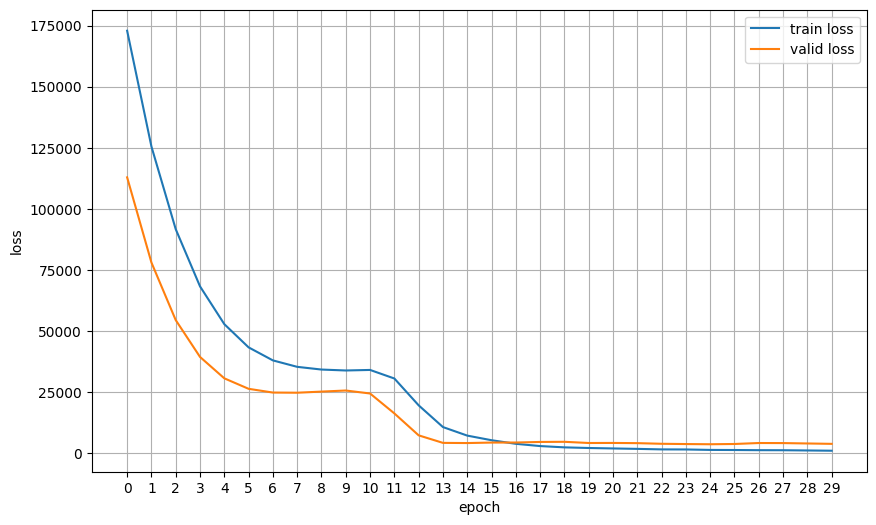

In [ ]:
# Plotting the loss
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(num_epochs))
ax.legend()
ax.grid()

In [ ]:
# After training, calculate MAE and RMSE
model.eval()
true_values = []
predicted_values = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        true_values.extend(y_batch.cpu().numpy())
        predicted_values.extend(outputs.cpu().numpy())

# Convert lists to numpy arrays
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)

# Test metrics
test_mae, test_mse, test_rmse, test_r2 = evaluate_metrics(true_values, predicted_values)
print("Test Metrics:")
print(f"MAE: {test_mae:.3f}, MSE: {test_mse:.3f}, RMSE: {test_rmse:.3f}, R-squared: {test_r2:.3f}")


Test Metrics:
MAE: 62.087, MSE: 6407.804, RMSE: 80.049, R-squared: 0.787


In [ ]:
results.append({
    'model': 'lstm',
    'mae': test_mae,
    'mse': test_mse,
    'rmse': test_rmse,
    'r2': test_r2,
    'emission': lstm_emissions
})

## Comparison

Performance and emission comparison between linear regression and LSTM models.

In [ ]:
df_result = pd.DataFrame(results)
# df_result = df_result.melt(id_vars='model', var_name='metric', value_name='value')
df_result

,model,mae,mse,rmse,r2,emission
0,linear regression,89.861673,11420.163045,106.865163,0.619629,0.000001
1,lstm,62.086617,6407.804199,80.048759,0.787181,0.000715


Text(0.5, 0, 'Model')

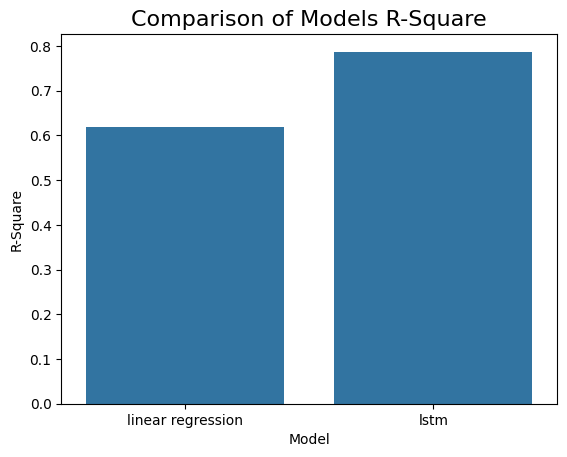

In [ ]:
sns.barplot(x='model', y='r2', data=df_result)

plt.title('Comparison of Models R-Square', fontsize=16)
plt.ylabel('R-Square')
plt.xlabel('Model')


Text(0.5, 0, 'Model')

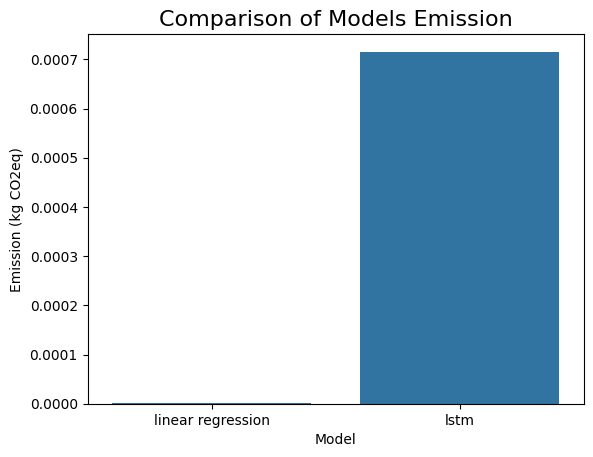

In [ ]:
sns.barplot(x='model', y='emission', data=df_result)

plt.title('Comparison of Models Emission', fontsize=16)
plt.ylabel('Emission (kg CO2eq)')
plt.xlabel('Model')

## Simulation

RCP8.5 Projection data for Los Angeles is obtained from MACA website with temperature and precipication for year 2024 to year 2099. Traffic data is simulated using LSTM model with updated temperature and precipication for year 2050 and 2099.

RCP 8.5 Project download for Los Angeles

- URL: https://climate.northwestknowledge.net/MACA/data_csv.php
- year 2024 - 2099
- RCP 8.5
- Los Angeles
- CCSM4 (USA) with tasmax(Max Temperature), pr(Precipitation)

In [ ]:
df_rcp = pd.read_csv('rcp_data.csv')
df_rcp.head()

,yyyy-mm-dd,tasmax_rcp85(K),huss,pr
0,2024-01-01,287.486938,0.005135,0.000000
1,2024-01-02,288.835388,0.005333,1.598677
2,2024-01-03,288.799164,0.003960,0.000000
3,2024-01-04,287.002045,0.002901,0.000000
4,2024-01-05,287.703918,0.003098,0.000000


In [ ]:
df_rcp = df_rcp.rename(columns={'yyyy-mm-dd': 'Date', 'tasmax_rcp85(K)': 'Temp'})
df_rcp.drop(columns=['huss'], inplace=True)
df_rcp['Date'] = pd.to_datetime(df_rcp['Date'])

In [ ]:
# Convert MaxTemp from Kelvin to Fahrenheit
df_rcp["Temp"] = (df_rcp["Temp"] - 273.15) * 9/5 + 32
df_rcp

,Date,Temp,pr
0,2024-01-01,57.806488,0.000000
1,2024-01-02,60.233698,1.598677
2,2024-01-03,60.168495,0.000000
3,2024-01-04,56.933681,0.000000
4,2024-01-05,58.197052,0.000000
...,...,...,...
27754,2099-12-27,58.696381,0.000000
27755,2099-12-28,57.502333,0.000000
27756,2099-12-29,53.823067,1.775312
27757,2099-12-30,60.326204,3.254704


### Simulate year 2050 and year 2099

In [ ]:
# load projected data, filter the 50 years: 2050, 2099
# use the model to predict flow using the updated temperature, precipitation
# plot the flow change patterns

In [ ]:
def simulate_future(year=2050):
    df_rcp_future = df_rcp[df_rcp['Date'].dt.year == year]
    df_origin = df.copy()
    # Extract day and month from both datasets for mapping
    df_origin['DayMonth'] = df_origin['DateTime'].dt.strftime('%m-%d')
    df_rcp_future['DayMonth'] = df_rcp_future['Date'].dt.strftime('%m-%d')

    df_synthesis_future = pd.merge(left=df_origin, right=df_rcp_future[['DayMonth', 'Temp', 'pr']], on='DayMonth')

    df_synthesis_future.drop(columns=['Temperature', 'Precip.'], inplace=True)
    df_synthesis_future.rename(columns={'Temp': 'Temperature', 'pr': 'Precip.'}, inplace=True)

    features = [col for col in df.columns if col not in ['DateTime', 'DayMonth', 'Day', 'Flow']]
    target = 'Flow'
    X = df_synthesis_future[features]
    y = df_synthesis_future[target].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create sequences for synthesis data
    X_seq, y_seq = create_sequences(X_scaled, y, seq_length)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32)

    # Create DataLoader
    X_dataset = TensorDataset(X_tensor, y_tensor)

    X_loader = DataLoader(X_dataset, batch_size=64, shuffle=False)

    model.eval()
    true_values = []
    predicted_values = []
    with torch.no_grad():
        for X_batch, y_batch in X_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            true_values.extend(y_batch.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())

    # Convert lists to numpy arrays
    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)

    plt.figure(figsize=(10, 6))
    sns.histplot(true_values, kde=False, label='Year 2020')
    sns.histplot(predicted_values.flatten(), kde=False, label=f'Year {year}')
    plt.title(f'Traffic Flow Distribution for Year 2020 vs Year {year}')
    plt.legend(loc='upper right')
    plt.xlabel('Traffic Flow')
    plt.ylabel('Frequency')
    plt.show()

<ipython-input-51-2706f0f8a98f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rcp_future['DayMonth'] = df_rcp_future['Date'].dt.strftime('%m-%d')


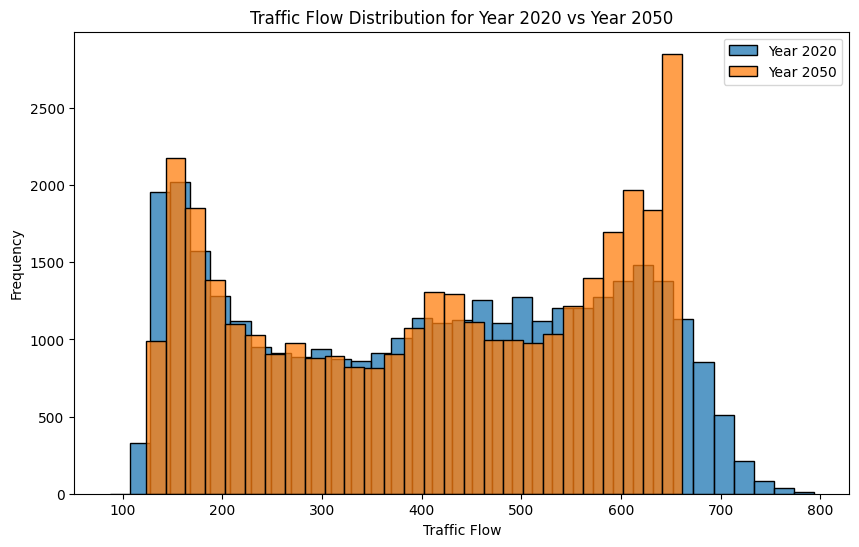

In [ ]:
simulate_future(year=2050)

<ipython-input-51-2706f0f8a98f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rcp_future['DayMonth'] = df_rcp_future['Date'].dt.strftime('%m-%d')


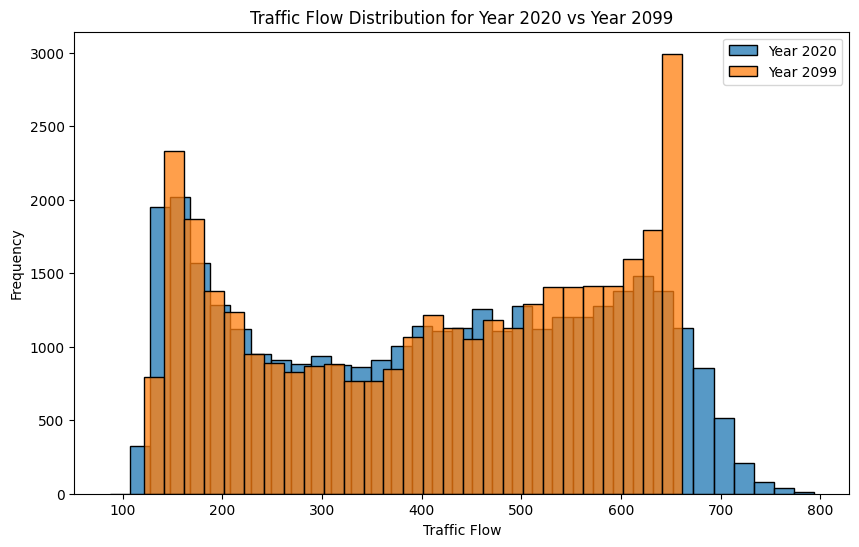

In [ ]:
simulate_future(year=2099)

## References

[1] Shoaeinaeini, Maryam, Oktay Ozturk, and Deepak Gupta. "Twitter-informed Prediction for Urban Traffic
Flow Using Machine Learning." 2022 6th International Conference on Universal Village (UV). IEEE, 2022.

[2] "Caltrans Performance Measurement System (PeMS)." California Department of Transportation, n.d.,
https://pems.dot.ca.gov/.

[3] "Transportation." CCAI Wiki, n.d., https://wiki.climatechange.ai/wiki/Transportation.

[4] Rolnick, David, et al. "Tackling climate change with machine learning." ACM Computing Surveys (CSUR)
55.2 (2022): 1-96.

[5] T. Product and T. LLC. “Los angeles, ca weather.” wunderground.com. https://www.wunderground.
com/history/daily/KLAX.

[6] https://climate.northwestknowledge.net/MACA/data_csv.php